# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using QuasiCopula
using Random
using GLM
using LinearAlgebra
using Statistics
using StatsBase

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
  ** incremental compilation may be fatally broken for this module **



1

## Simulate data

All SNPs have the same MAF

In [36]:
k = 0 # number of causal SNPs

qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
    n = 10_000, # sample size
    d_min = 5, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 15, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 100, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2024,
    y_distribution = Bernoulli,
    τtrue = 0.5,
    T = Float64,
    maf = 0.3,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 10000
  * cluster size min, max: 5, 5
  * number of variance components: 2
  * number of fixed effects: 15



In [64]:
# simulated Γ
Γ = qc_model.data[1].V[1] * θtrue[1] + qc_model.data[1].V[2] * θtrue[2]

5×5 Matrix{Float64}:
 0.11  0.1   0.1   0.1   0.1
 0.1   0.11  0.1   0.1   0.1
 0.1   0.1   0.11  0.1   0.1
 0.1   0.1   0.1   0.11  0.1
 0.1   0.1   0.1   0.1   0.11

In [51]:
# check response
Y = hcat([qc_model.data[i].y for i in 1:length(qc_model.data)]...)'
Statistics.cor(Y)

5×5 Matrix{Float64}:
 1.0        0.035792   0.0221966  0.0158976  0.0230644
 0.035792   1.0        0.0222266  0.0302293  0.0236656
 0.0221966  0.0222266  1.0        0.0290245  0.0282382
 0.0158976  0.0302293  0.0290245  1.0        0.0249469
 0.0230644  0.0236656  0.0282382  0.0249469  1.0

In [52]:
Y

10000×5 adjoint(::Matrix{Float64}) with eltype Float64:
  3.93727   -2.34964     1.15502    0.845882   -2.25056
  1.239     -1.41874     1.10158   -1.54951     1.55236
 -2.26558   -3.68031     2.20243    1.10832     1.05051
  1.94291    0.630906   -0.123103   2.12125     1.27238
 -0.256513   2.95857    -4.80642   -0.289042   -2.71634
  2.48586    6.17372    -2.65617   -0.834607    1.30696
  1.00082    1.04486    -3.16515    0.290777    3.01215
  4.06211   -3.00305    -0.199011   4.43849     2.42237
  1.33301   -5.50109     1.94873    6.30419    -0.478857
  2.67229    2.43302     0.611184  -0.505642   -0.300268
  2.63139    5.73512     4.93054   -0.52798    -1.54477
  1.54158   -0.164176   -1.30372    0.8517      0.284256
  4.39541    1.82224     1.52061    1.25152    -1.28981
  ⋮                                            
  2.36584   -2.10804     0.968788   1.32022     3.81198
  2.13142   -2.20301     2.96436   -2.32653     3.96701
  4.53744   -3.48772     1.71259    0.0926616  -2.641

Mathematically, $cov(Y_k, Y_l) = \sigma_k\sigma_l\gamma_{kl}$. Lets check this.

In [15]:
k = 1
l = 2

# bernoulli
pk = count(isone, Y[:, k]) / size(Y, 1)
pl = count(isone, Y[:, l]) / size(Y, 1)
σk = sqrt(pk * (1 - pk))
σl = sqrt(pl * (1 - pl))

# gaussian
# σk = std(Y[:, k])
# σl = std(Y[:, l])

σk * σl * Γ[k, l]

24.229478198003438

## Fit null model

In [37]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-3, 
        max_iter = 1000,
        accept_after_max_steps = 50,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
        derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.


No errors detected by derivative checker.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       17
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:  

In [38]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show τtrue
@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, -0.5, 0.5, 0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0.5, -0.5, 0.5, -0.5, -0.5]
qc_model.β = [0.9853555409028882, -0.4979946697828196, 0.5064177320008206, 0.48781532512845277, 0.48798507812527553, -0.5119158184148657, 0.4844263285008625, -0.5024894414672625, 0.47713361346428196, -0.46024885802320736, -0.48471323266709004, -0.5171468151704981, 0.5144289091432042, -0.5072728211326516, -0.510474748044049]
qc_model.∇β = [-0.001068839522005982, -0.0009538451524853109, 0.001358971126670494, 0.0002132900058282594, -0.00037532718890054273, 0.0009998413032568099, -0.00021706367757989842, -0.0002167356743429938, -0.0019829310505408426, 0.0006124410109808465, -0.0012530995672765943, 3.746821109007481e-5, 0.00016903569341564229, 0.0002483502075300015, 0.0006176535041252929]
θtrue = [0.1, 0.1]
qc_model.θ = [0.0943726296628309, 0.15385215967084837]
qc_model.∇θ = [-0.00067719381584741, 6.281313794342935e-5]
τtrue = 0.5
qc_model.τ = [1.0]
qc_model.∇τ = [2.4603331626e-314]


## Score test GWAS

In [42]:
# Gaussian case
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)
[pvals pvals2]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Wtime = 1.3679050610078385
Qtime = 0.48626795000053247
Rtime = 0.16739714399800315
grad_res_time = 0.26252065199992874
othertime = 0.30817723099958994
scoretest_time = 0.003295501
  3.771406 seconds (1.94 M allocations: 1.331 GiB, 6.44% gc time, 11.92% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


grad time = 1.4178918729999999
hess time = 10.916995796
 16.346463 seconds (8.60 M allocations: 556.686 MiB, 0.41% gc time, 26.61% compilation time)


100×2 Matrix{Float64}:
 0.57271    0.57271
 0.810632   0.810632
 0.75852    0.75852
 0.827898   0.827898
 0.249886   0.249886
 0.548647   0.548647
 0.138826   0.138826
 0.912742   0.912742
 0.520199   0.520199
 0.241944   0.241944
 0.455017   0.455017
 0.798505   0.798505
 0.411922   0.411922
 ⋮          
 0.905393   0.905393
 0.355617   0.355617
 0.247256   0.247256
 0.86826    0.86826
 0.187647   0.187647
 0.463496   0.463496
 0.398405   0.398405
 0.236038   0.236038
 0.720063   0.720063
 0.0997096  0.0997096
 0.154153   0.154153
 0.996457   0.996457

In [19]:
# 3/13/2024 optimized away allocations + inline (N=100,000, P=15, d=5 obs per sample, Bernoulli)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Wtime = 13.823160521727385
Qtime = 4.8231576666749
Rtime = 1.7943300880687147
grad_res_time = 2.74373440804863
othertime = 3.342375513974367
scoretest_time = 0.001090289
 32.172534 seconds (12.59 M allocations: 12.820 GiB, 2.32% gc time, 0.52% compilation time)


100-element Vector{Float64}:
 0.6187728572609951
 0.8496667233330221
 0.40974196937222623
 0.5671957640255685
 0.46214111768624644
 0.7807307761430159
 0.002915186427295331
 0.9081736689430064
 0.08427231587790641
 0.737858003745425
 0.23694038429038083
 0.8833033494335396
 0.6129319697421085
 ⋮
 0.008245693236827225
 0.6310435761356239
 0.02900575228042566
 0.3050493485911325
 0.04485059136883662
 0.05784310364023999
 0.2692557868556426
 0.7408150252581713
 0.8663919149998177
 0.32387023749450206
 0.11494644685131016
 0.37332203886960197

In [14]:
# 3/13/2024 optimized away allocations (N=100,000, P=15, d=5 obs per sample, Bernoulli)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


Wtime = 15.692459615067392
Qtime = 5.059108313710545
Rtime = 1.8031709030744016
 32.868250 seconds (12.42 M allocations: 12.810 GiB, 1.37% gc time)


100-element Vector{Float64}:
 0.6187728572609951
 0.8496667233330221
 0.40974196937222623
 0.5671957640255685
 0.46214111768624644
 0.7807307761430159
 0.002915186427295331
 0.9081736689430064
 0.08427231587790641
 0.737858003745425
 0.23694038429038083
 0.8833033494335396
 0.6129319697421085
 ⋮
 0.008245693236827225
 0.6310435761356239
 0.02900575228042566
 0.3050493485911325
 0.04485059136883662
 0.05784310364023999
 0.2692557868556426
 0.7408150252581713
 0.8663919149998177
 0.32387023749450206
 0.11494644685131016
 0.37332203886960197

In [36]:
# 3/11/2024 pre-optimizing (N=100,000, P=15, d=5 obs per sample, Bernoulli)
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


Wtime = 151.45075288451383
Qtime = 14.949879267721332
Rtime = 2.5083309525981132
193.969275 seconds (1.49 G allocations: 210.847 GiB, 18.29% gc time)


100-element Vector{Float64}:
 0.6187728572609951
 0.8496667233330198
 0.4097419693722258
 0.5671957640255666
 0.4621411176862497
 0.780730776143015
 0.00291518642729541
 0.9081736689430064
 0.08427231587790672
 0.7378580037454281
 0.23694038429038128
 0.8833033494335386
 0.6129319697421055
 ⋮
 0.008245693236827153
 0.6310435761356203
 0.029005752280425737
 0.3050493485911328
 0.04485059136883624
 0.057843103640240055
 0.2692557868556421
 0.7408150252581676
 0.8663919149998188
 0.3238702374944988
 0.11494644685131038
 0.3733220388696007

In [26]:
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false) 
@time pvals2 = GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)
[pvals1 pvals2]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 19.305981 seconds (149.26 M allocations: 21.086 GiB, 24.29% gc time)
loglikelihood(par) = -27003.48634665121
get_grad_last(γ) = 54.60960429046459
  0.007651 seconds (41 allocations: 4.078 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


grad time = 0.8811622880000001
hess time = 9.796995043
 11.779072 seconds (37.39 k allocations: 8.655 MiB)


100×2 Matrix{Float64}:
 0.410184    0.410184
 0.586272    0.586272
 0.598494    0.598494
 0.00303473  0.00303473
 0.175519    0.175519
 0.880568    0.880568
 0.856739    0.856739
 0.487394    0.487394
 0.29277     0.29277
 0.620851    0.620851
 0.0687728   0.0687728
 0.448751    0.448751
 0.115359    0.115359
 ⋮           
 0.970078    0.970078
 0.282901    0.282901
 0.579532    0.579532
 0.472453    0.472453
 0.993304    0.993304
 0.175282    0.175282
 0.909272    0.909272
 0.479745    0.479745
 0.721487    0.721487
 0.615525    0.615525
 0.411245    0.411245
 0.862402    0.862402

In [25]:
pvals = GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false) 

loglikelihood(par) = -27003.48634665121
get_grad_last(γ) = 54.60960429046459
  0.009179 seconds (41 allocations: 4.078 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


grad time = 0.8810109629999998
hess time = 10.874245159999997


100-element Vector{Float64}:
 0.4101839867442275
 0.5862718157013809
 0.5984937206557013
 0.003034727581604222
 0.17551870951777954
 0.8805682545747121
 0.8567387490099405
 0.4873935471580367
 0.29276960872536617
 0.6208507372096588
 0.06877280527475794
 0.44875056307610356
 0.11535947258665749
 ⋮
 0.970078145792238
 0.28290134175263415
 0.579532247105551
 0.4724532428064645
 0.9933042928968554
 0.1752823127861532
 0.9092716158919599
 0.4797452036799379
 0.7214873906350371
 0.6155248961503867
 0.41124522603559177
 0.8624015377849512

In [23]:
pvals = QuasiCopula.GWASCopulaVCModel_enzyme(qc_model, G, check_grad=false) 

LoadError: MethodError: no method matching Zygote.Buffer(::Int64)

[0mClosest candidates are:
[0m  Zygote.Buffer([91m::A[39m, [91m::Bool[39m) where {T, A<:(AbstractArray{T})}
[0m[90m   @[39m [36mZygote[39m [90m~/.julia/packages/Zygote/jxHJc/src/tools/[39m[90m[4mbuffer.jl:38[24m[39m
[0m  Zygote.Buffer([91m::AbstractArray[39m, [91m::Any...[39m)
[0m[90m   @[39m [36mZygote[39m [90m~/.julia/packages/Zygote/jxHJc/src/tools/[39m[90m[4mbuffer.jl:42[24m[39m


In [ ]:
pvals3 = QuasiCopula.GWASCopulaVCModel_enzyme(qc_model, G, check_grad=false) 

In [7]:
# Normal (n=100_000, m=2, p=15, q=100)
pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G, check_grad=false) 
pvals3 = GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false) 
[pvals1 pvals2 pvals3]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
Progress: 100%|█████████████████████████████████████████| Time: 0:16:44
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


100×3 Matrix{Float64}:
 0.309198   0.309178   0.309178
 0.65743    0.657418   0.657418
 0.130797   0.130769   0.130769
 0.957161   0.957161   0.957161
 0.490949   0.490936   0.490936
 0.674417   0.674407   0.674407
 0.0206968  0.0206746  0.0206746
 0.30308    0.303065   0.303065
 0.829673   0.829654   0.829654
 0.210698   0.210664   0.210664
 0.749992   0.749991   0.749991
 0.269138   0.269123   0.269123
 0.995939   0.995939   0.995939
 ⋮                     
 0.618831   0.618798   0.618798
 0.221689   0.221634   0.221634
 0.966925   0.966925   0.966925
 0.348356   0.348333   0.348333
 0.212692   0.21267    0.21267
 0.762958   0.76295    0.76295
 0.584168   0.584168   0.584168
 0.370048   0.370025   0.370025
 0.360879   0.360867   0.360867
 0.454855   0.454847   0.454847
 0.779821   0.779819   0.779819
 0.97258    0.972578   0.972578

In [32]:
# Bernoulli (n=10_000, m=2, p=15, q=1000)
pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G, check_grad=false) 
pvals3 = GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false) 
[pvals1 pvals2 pvals3]

Progress:   3%|█▏                                       |  ETA: 0:01:47

LoadError: InterruptException:

## QQ plots

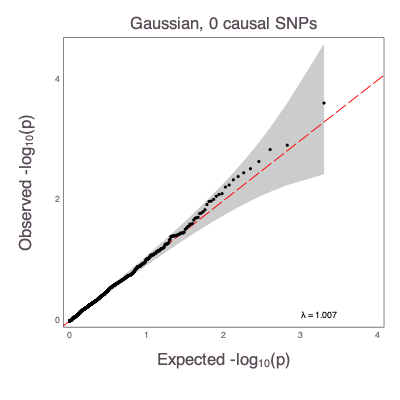

In [12]:
# gaussian
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs")
display("image/png", read("qqplot.png"))

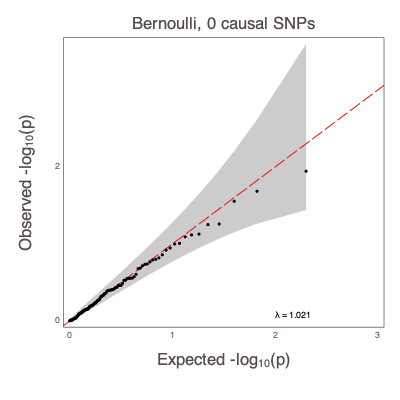

In [27]:
# Bernoulli
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

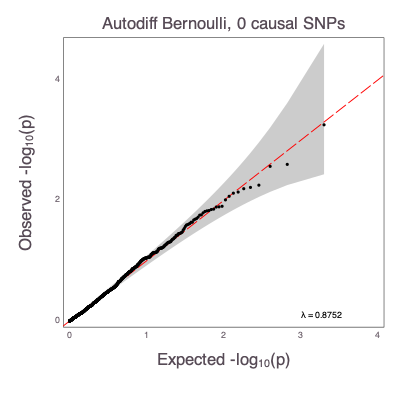

In [24]:
qq(pvals, dpi=80, titles="Autodiff Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))